In [1]:
import numpy as np
import pandas as pd

# 랜덤 시드 고정
np.random.seed(42)

# 모집단 평균과 표준편차 설정
mu_x1, sigma_x1 = 70, 10
mu_x2, sigma_x2 = 50, 15

# 100명의 index, name 생성
index = np.arange(1, 101)
names = [f"Person_{i:03d}" for i in index]

# 정규분포 기반 점수 생성 (정규화된 분포를 가정)
x1 = np.random.normal(mu_x1, sigma_x1, size=100)
x2 = np.random.normal(mu_x2, sigma_x2, size=100)

# 데이터프레임 구성
df = pd.DataFrame({
    'index': index,
    'name': names,
    'x1': x1,
    'x2': x2
})

In [2]:
df

,index,name,x1,x2
0,1,Person_001,74.967142,28.769439
1,2,Person_002,68.617357,43.690320
2,3,Person_003,76.476885,44.859282
3,4,Person_004,85.230299,37.965841
4,5,Person_005,67.658466,47.580714
...,...,...,...,...
95,96,Person_096,55.364851,55.779761
96,97,Person_097,72.961203,36.742138
97,98,Person_098,72.610553,52.305877
98,99,Person_099,70.051135,50.873131


In [10]:
# mac 한글 폰트
import matplotlib.pyplot as plt
import matplotlib as mpl

# macOS에서 한글 깨짐 방지
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 음수 부호 깨짐 방지

In [ ]:
# window 한글 폰트
import matplotlib.pyplot as plt
import matplotlib as mpl

# Windows에서 한글 깨짐 방지
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

    count       mean        std        min        25%        50%        75%  \
x1  100.0  68.961535   9.081684  43.802549  63.990943  68.730437  74.059521   
x2  100.0  50.334569  14.305034  21.218432  37.915092  51.261608  58.072557   

          max  
x1  88.522782  
x2  90.802537  


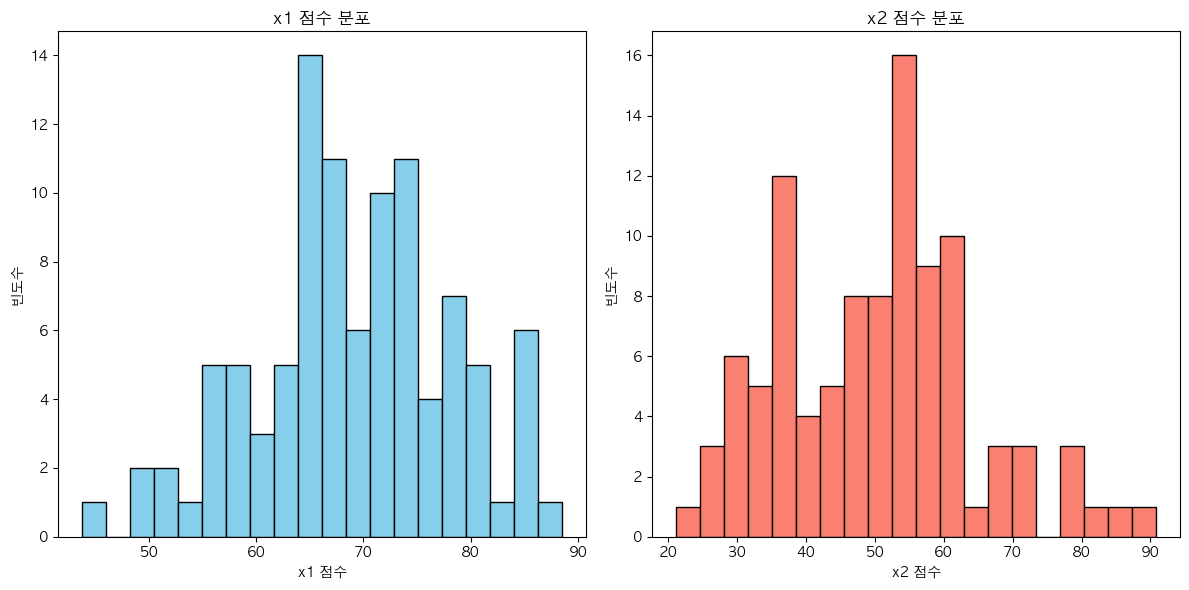

In [11]:
import matplotlib.pyplot as plt

subplots = df[['x1', 'x2']].describe().T
print(subplots)

# 서브플롯으로 동시 시각화
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# x1 히스토그램
axes[0].hist(df["x1"], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("x1 점수 분포")
axes[0].set_xlabel("x1 점수")
axes[0].set_ylabel("빈도수")

# x2 히스토그램
axes[1].hist(df["x2"], bins=20, color='salmon', edgecolor='black')
axes[1].set_title("x2 점수 분포")
axes[1].set_xlabel("x2 점수")
axes[1].set_ylabel("빈도수")
plt.tight_layout()
plt.show()

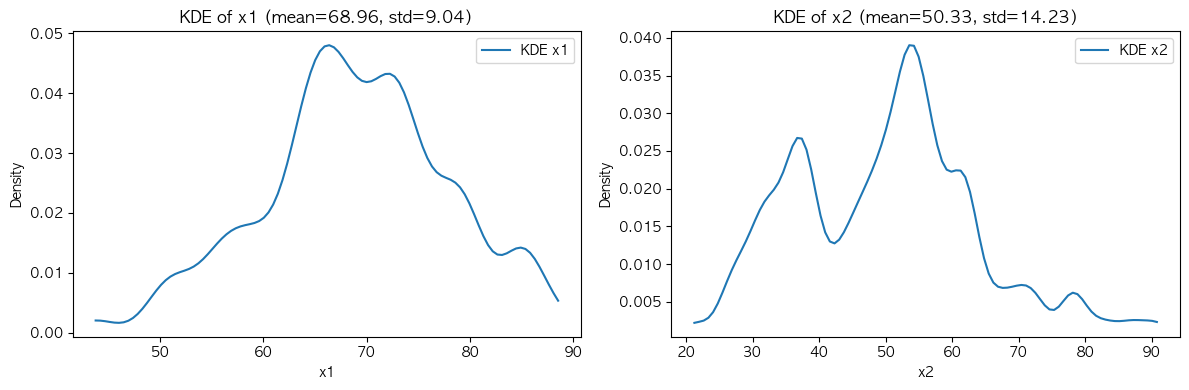

In [27]:
# 모집단 데이터로 baseline 생성
data = df[['x1', 'x2']].to_numpy()

def compute_population_stats(X):
    from sklearn.neighbors import KernelDensity
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, X.shape[1], figsize=(12, 4))

    for dim in range(X.shape[1]):
        x = X[:, dim][:, np.newaxis]
        mean = x.mean()
        std = x.std()

        kde = KernelDensity(kernel='gaussian', bandwidth=2.0).fit(x) # 각 데이터 포인트에 정규분포를 씌워서 분포 추정, 커널의 폭 -> 해당 값이 추후 최적화에 활용됨
        xplot = np.linspace(x.min(), x.max(), 100)[:, np.newaxis] # newaxis : 1차원을 강제로 2차원으로 변환
        log_dens = kde.score_samples(xplot) # 각 x좌표에 대한 로그 확률 밀도값(log density) 계산
        kde_vals = np.exp(log_dens) # 확률 밀도값으로 변환

        axs[dim].plot(xplot[:, 0], kde_vals, label=f'KDE x{dim+1}')
        axs[dim].set_title(f'KDE of x{dim+1} (mean={mean:.2f}, std={std:.2f})')
        axs[dim].set_xlabel(f'x{dim+1}')
        axs[dim].set_ylabel('Density')
        axs[dim].legend()

    plt.tight_layout()
    plt.show()

    return mean, std, kde
mean, std, kde = compute_population_stats(data)

In [33]:
df[['x1', 'x2']].shape

(100, 2)

In [ ]:
from sklearn.cluster import KMeans

def initialize_clusters(X, k, method='random', random_state=None): # random_state: 랜덤 시드 설정
    """
    초기 군집 할당 함수.
    - method='random' : 완전 무작위 군집 할당
    - method='kmeans' : KMeans 초기 클러스터링 결과 사용
    """
    n_samples = X.shape[0] # 데이터 샘플 수

    if method == 'random':
        rng = np.random.default_rng(seed=random_state) # 랜덤 넘버 생성기
        labels = rng.integers(0, k, size=n_samples) # 0부터 k-1까지의 정수 중 무작위로 할당

    elif method == 'kmeans':
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state) # n_init: KMeans 알고리즘을 n_init 번 실행하여 최적의 클러스터링을 찾음
        labels = kmeans.fit_predict(X)

    else:
        raise ValueError("method must be either 'random' or 'kmeans'")

    return labels

# 테스트: 랜덤 방식
labels_random = initialize_clusters(data, k=3, method='random', random_state=42)
# 테스트: KMeans 방식
labels_kmeans = initialize_clusters(data, k=3, method='kmeans', random_state=42)

# 출력: 두 방식 비교 (처음 10개 라벨)
labels_random[:10], labels_kmeans[:10]

# ! 이렇게 하면 군집 내 크기가 서로 달라지게 됨.

(array([0, 2, 1, 1, 1, 2, 0, 2, 0, 0]),
 array([1, 1, 1, 1, 0, 0, 2, 0, 0, 0], dtype=int32))

In [ ]:
# 우선 랜덤한 방식으로 진행
# 군집 수 만큼 라벨 값을 만들고
# 전체 데이터 수 / 군집 수 만큼의 각 라벨 값을 생성하고
# 합친 후 셔플해서 반환하는 과정
def initialize_clusters(X, k, random_state=None): # random_state: 랜덤 시드 설정
    if random_state is not None:
        np.random.seed(random_state)
        
    labels_list = [label for label in range(k)]
    n_samples = X.shape[0]  # 데이터 샘플 수
    labels = np.array(labels_list * (n_samples // k))  # 각 라벨
    if n_samples % k != 0:  # 나머지가 있다면
        labels = np.concatenate([labels, np.random.choice(labels_list, n_samples % k)])  # 나머지 라벨 추가
    else:
        pass
    labels = np.random.permutation(labels)  # 셔플
    return labels
# 테스트: 랜덤 방식
labels_random = initialize_clusters(data, k=4, random_state=42)
# 출력: 라벨 확인
labels_random[:10]  # 처음 10개 라벨 출력

array([3, 0, 3, 0, 1, 1, 2, 3, 3, 1])

In [ ]:
labels_random

array([3, 0, 3, 0, 1, 1, 2, 3, 3, 1, 2, 0, 0, 3, 2, 3, 1, 1, 2, 2, 0, 3,
       2, 3, 3, 2, 0, 0, 0, 2, 2, 1, 3, 1, 3, 2, 1, 1, 1, 2, 2, 3, 2, 1,
       3, 3, 1, 1, 1, 2, 1, 0, 0, 3, 3, 2, 1, 0, 0, 0, 1, 3, 2, 1, 0, 0,
       3, 0, 1, 2, 0, 3, 3, 1, 2, 2, 0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 0, 0,
       3, 0, 3, 0, 3, 2, 3, 2, 1, 3, 2, 0])

In [ ]:
# 손실함수 구현
from sklearn.neighbors import KernelDensity

def compute_loss(X, labels, k, pop_mean, pop_std, pop_kde):
    """
    주어진 군집 라벨에 따라 손실 값을 계산합니다.
    - 각 군집의 평균, 표준편차, KDE 분포를 모집단 기준과 비교하여 손실을 합산합니다.
    
    Returns:
        total_loss: 전체 손실 (L_mean + L_std + L_kde)
        cluster_means: 각 군집 평균 리스트
        cluster_stds: 각 군집 표준편차 리스트
        cluster_kdes: 각 군집 KDE 리스트 (x축 고정)
    """
    L_mean, L_std, L_kde = 0.0, 0.0, 0.0
    cluster_means, cluster_stds, cluster_kdes = [], [], []

    xplot = np.linspace(X.min(), X.max(), 100)[:, np.newaxis]
    for cluster_id in range(k):
        cluster_data = X[labels == cluster_id] # 불리언 인덱싱을 사용하여 해당 군집의 데이터 추출
        if len(cluster_data) == 0:
            continue  # 비어있는 군집은 건너뜀

        # 평균 및 표준편차 손실
        cluster_mean = cluster_data.mean()
        cluster_std = cluster_data.std()
        cluster_means.append(cluster_mean)
        cluster_stds.append(cluster_std)
        L_mean += (cluster_mean - pop_mean) ** 2
        L_std += (cluster_std - pop_std) ** 2

        # KDE 분포 차이 손실
        kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(cluster_data)
        log_dens = kde.score_samples(xplot)
        cluster_density = np.exp(log_dens)
        kde_diff = cluster_density - pop_kde
        L_kde += np.mean(kde_diff ** 2)
        cluster_kdes.append(cluster_density)

    total_loss = L_mean + L_std + L_kde
    return total_loss, cluster_means, cluster_stds, cluster_kdes
# ! kde 분포 차이를 구하는 손실 함수에서 평균값의 차이로 구하는 것에 의문점이 존재하며, 밀도 값으면 계산되는건지? 정확히 어떠한 평균인지에 대해서 확인이 필요함

In [46]:
test_list = ['a','b','c','d','e','f','g','h','i','j']
boolean_list = [True, False, True, False, True, False, True, False, True, False]
test_list[boolean_list]  # 불리언 인덱싱을 사용하여 True인 인덱스의 값만 추출
# ! 리스트에는 불리언 인덱싱이 적용되지 않음

TypeError: list indices must be integers or slices, not list

In [ ]:
import numpy as np
test_array = np.array(['a','b','c','d','e','f','g','h','i','j'])
boolean_mask = np.array([True, False, True, False, True, False, True, False, True, False])

test_array[boolean_mask]
# ! 넘파이 배열에는 불리언 인덱싱이 적용됨

array(['a', 'c', 'e', 'g', 'i'], dtype='<U1')

In [ ]:
# 최적화 함수
def optimize_clusters(X, k, pop_mean, pop_std, pop_kde, max_iter=50, balance_tol=5, random_state=None):
    n_samples = X.shape[0]
    labels = initialize_clusters(X, k, random_state=random_state)
    loss_history = []

    for iteration in range(max_iter):
        changed = False
        current_loss, _, _, _ = compute_loss(X, labels, k, pop_mean, pop_std, pop_kde)
        loss_history.append(current_loss)

        for idx in range(n_samples):
            original_cluster = labels[idx]
            best_cluster = original_cluster
            best_loss = current_loss

            for new_cluster in range(k):
                if new_cluster == original_cluster:
                    continue

                label_counts = np.bincount(labels, minlength=k)
                if label_counts[new_cluster] + 1 > label_counts.mean() + balance_tol:
                    continue
                if label_counts[original_cluster] - 1 < label_counts.mean() - balance_tol:
                    continue

                temp_labels = labels.copy()
                temp_labels[idx] = new_cluster
                temp_loss, _, _, _ = compute_loss(X, temp_labels, k, pop_mean, pop_std, pop_kde)

                if temp_loss < best_loss:
                    best_loss = temp_loss
                    best_cluster = new_cluster

            if best_cluster != original_cluster:
                labels[idx] = best_cluster
                changed = True

        if not changed:
            print(f"Converged at iteration {iteration+1}")
            break

    return labels, loss_history